In [2]:
from src.visualisers.abstract_gui import AbstractGUI, SignalFrame

import numpy as np
from src.sources.fft import FFTSource
import matplotlib.pyplot as plt

from collections import deque
import cv2
import time
import tkinter as tk
from PIL import Image, ImageTk

import math

from src.visualisers.camera_gui import display
from src.sources.video_helper import get_differences, get_differences_2D
from src.var_processor.pb_threshold import pb_threshold

In [25]:
fftsource = FFTSource(res_factor=2)
fftsource.start()

In [ ]:
class MeanBuffer:
    """This is similar to our sensor and buffer objects."""
    
    def __init__(self, data_len, stages, time_period):
        """Initialise.
        
        Args:
            data_len - integer length of 1D array being processed.
            stages - number of spatial stages being processed.
            time_period - number of time steps for buffering.
        """
        self.time_period = time_period
        # Define a general count for the rolling sum
        self.count = 0
        # Define a count for the buffer entries
        self.buffer_count = 0
        # Define rolling sums for each layer (including lowest)
        self.running_sum = np.zeros(
            shape=(data_len, stages), 
            dtype=np.int16
        )
        # Define in parallel a rolling buffer
        self.buffered_means = np.zeros(
            shape=(data_len, stages, time_period), 
            dtype=np.int16
        )
        # Define a flag that indicates buffer data is available
        self.use_buffer = False
        
    def iterate(self, input_data, buffer_data):
        """Iterate using input_data.
        
        Args:
            input_data - 2D array the same size as running_sum.
                This is the data from each time step.
            buffer_data - 2D array representing an input from a buffer
                above (e.g. shorter time period).
        Returns:
            """
        # Set a flag for returning buffer data
        return_buffer = False
        # Don't return anything until buffer is full
        return_data = None
        # Use rolling sum if no data in buffer 
        if not self.use_buffer:
            self.count += 1
            self.running_sum += input_data
            # Check for overflow on running sum
            if self.count >= 2**16-1:
                self.count = self.count // 2
                self.running_sum = self.running_sum // 2
        # Check if buffer data
        if buffer_data is not None:
            self.buffered_means[..., self.buffer_count] = buffer_data.ravel()
            self.buffer_count += 1
            if (self.buffer_count) % self.time_period == 0:
                # Stop with the rolling sum
                # Reset buffer count
                self.buffer_count = 0
                self.use_buffer = True
                return_buffer = True
        if return_buffer:
            return_data = self.mean_probs
        return return_data
    
    @property
    def mean_probs(self):
        """Return mean probabilities."""
        # If no buffered mean
        if self.use_buffer:
            mean_probs = self.buffered_means / self.time_period
        else:
            mean_probs = self.running_sum / self.count
        return mean_probs
    
    def __repr__(self):
        """Print output."""
        return self.mean_probs

So the MeanBuffer above is a mean stage for a plurality of spatial levels or stages. 

It outputs mean probabilities not mean values - i.e. dimensionless ratios. So what is a "difference" between time stages?

Spatial stages may be considered to do the same - they output a probability - e.g. ```[1, 0, 1, 1] . [1, 1, 1, 1]/4```> 0.75. But pyrDown only outputs binary values - it uses a Gaussian kernel. 

***So we could create a version of mean buffer that pyrDown the time samples as opposed to using a running sum.*** BUT we ***don't*** because we don't have access to all the time samples, and having access would be too onerous.

* A first visualisation can look just at the averages of the original signal in both space and time. This would be pyrDown on the binary input and the MeanBuffer

In this notebook we are filtering in Time using a Gaussian filter - 
* https://github.com/benhoyle/predictive_coding/blob/master/Filtering%20in%20Time%20v4%20-%20Clipping%20%26%20Convolve.ipynb.
* https://github.com/benhoyle/predictive_coding/blob/master/Time%20Filtering.ipynb.

In [15]:
start = np.ones(2)
for i in range(20):
    output = np.convolve(start, np.ones(2))
    print(output)
    start = output

start = np.ones(2)
for i in range(20):
    output = np.convolve(start, np.ones(2))
    print(output/output.sum())
    start = output

[1. 2. 1.]
[1. 3. 3. 1.]
[1. 4. 6. 4. 1.]
[ 1.  5. 10. 10.  5.  1.]
[ 1.  6. 15. 20. 15.  6.  1.]
[ 1.  7. 21. 35. 35. 21.  7.  1.]
[ 1.  8. 28. 56. 70. 56. 28.  8.  1.]
[  1.   9.  36.  84. 126. 126.  84.  36.   9.   1.]
[  1.  10.  45. 120. 210. 252. 210. 120.  45.  10.   1.]
[  1.  11.  55. 165. 330. 462. 462. 330. 165.  55.  11.   1.]
[  1.  12.  66. 220. 495. 792. 924. 792. 495. 220.  66.  12.   1.]
[1.000e+00 1.300e+01 7.800e+01 2.860e+02 7.150e+02 1.287e+03 1.716e+03
 1.716e+03 1.287e+03 7.150e+02 2.860e+02 7.800e+01 1.300e+01 1.000e+00]
[1.000e+00 1.400e+01 9.100e+01 3.640e+02 1.001e+03 2.002e+03 3.003e+03
 3.432e+03 3.003e+03 2.002e+03 1.001e+03 3.640e+02 9.100e+01 1.400e+01
 1.000e+00]
[1.000e+00 1.500e+01 1.050e+02 4.550e+02 1.365e+03 3.003e+03 5.005e+03
 6.435e+03 6.435e+03 5.005e+03 3.003e+03 1.365e+03 4.550e+02 1.050e+02
 1.500e+01 1.000e+00]
[1.000e+00 1.600e+01 1.200e+02 5.600e+02 1.820e+03 4.368e+03 8.008e+03
 1.144e+04 1.287e+04 1.144e+04 8.008e+03 4.368e+03 1.820e+03

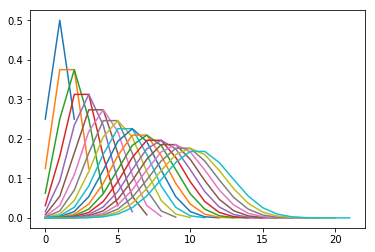

In [13]:
start = np.ones(2)
for i in range(20):
    output = np.convolve(start, np.ones(2))
    plt.plot(output/output.sum())
    start = output

In [10]:
start = np.ones(2)
for i in range(8):
    output = np.convolve(start, np.ones(2), mode="valid")
    print(output)
    start = output

[2.]
[2. 2.]
[4.]
[4. 4.]
[8.]
[8. 8.]
[16.]
[16. 16.]


In [17]:
first_conv = np.convolve(np.ones(2), np.ones(2))
second_conv = np.convolve(first_conv, np.asarray([1, -1]))
print(first_conv, second_conv)
# Hadamard - V

[1. 2. 1.] [ 1.  1. -1. -1.]


In [18]:
A_filter = np.ones(2)
D_filter = np.asarray([1, -1])
first_conv = np.convolve(D_filter, D_filter)
second_conv = np.convolve(first_conv, A_filter)
print(first_conv, second_conv)
# Hadamard - Diag

[ 1 -2  1] [ 1. -1. -1.  1.]




What's Hadamard H?
```V = A_2*D_2*A_2```
```Diag = A_2*D_2*D_2```

In [24]:
first_conv = np.convolve(D_filter, A_filter)
second_conv = np.convolve(first_conv, A_filter)
print(first_conv, second_conv)
first_conv = np.convolve(D_filter, A_filter)
second_conv = np.convolve(first_conv, D_filter)
print(first_conv, second_conv)

[ 1.  0. -1.] [ 1.  1. -1. -1.]
[ 1.  0. -1.] [ 1. -1. -1.  1.]


Ah the same as it doesn't matter about order.

In [26]:
_, data = fftsource.read()

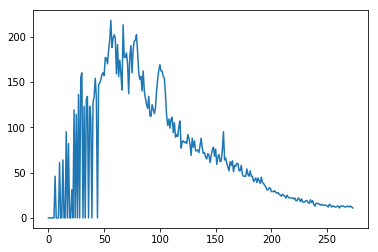

In [27]:
plt.plot(data)

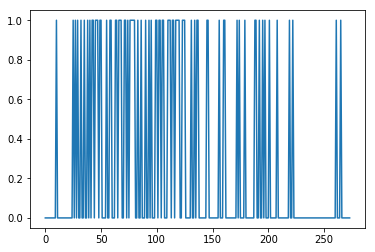

In [28]:
binary = pb_threshold(data)
plt.plot(binary)

In [29]:
binary.shape

(274,)

In [31]:
padded = np.pad(binary, (1, 1), 'constant', constant_values=(0))

In [33]:
print(padded.shape, padded)

(276,) [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1
 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 1
 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0
 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [34]:
%%timeit 
padded = np.pad(binary, (1, 1), 'constant', constant_values=(0))

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})
ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})
ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})
ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})
ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})
ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})


52.1 µs ± 685 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [46]:
input_data = binary.copy()
for i in range(16):
    padded = np.pad(input_data, (1, 1), 'constant', constant_values=(0))
    filtered = padded[1:] + padded[:-1]
    print(i, filtered, ((filtered/(2**i))*255).astype(np.uint8), sep="\n")
    input_data = filtered

0
[0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1
 0 1 1 1 1 1 2 1 1 2 2 1 1 2 1 0 0 0 1 1 0 1 2 1 0 0 1 2 1 1 2 2 1 0 1 2 1
 1 1 1 2 2 2 2 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 2 1 1 2 1 1 2 1 0 0 1
 2 2 1 1 2 1 1 2 2 2 1 0 1 2 2 1 0 0 0 0 1 1 0 1 1 1 2 1 0 0 0 0 0 0 1 2 1
 0 0 0 0 0 0 0 0 1 1 0 0 1 2 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0
 0 0 0 1 2 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0   0   0   0 255 255   0   0   0   0   0   0
   0   0   0   0   0   0   0 255 255 255 255 255 255   0 255 255   0 255
 255   0 255 255 255 255 255 254 255 255 254 254 255 255 254 255   0   0
   0 255 255   0 255 254 255   0   0 255 254 255 255 254 254 255   0 255
 254 255 255 255 255 254 254 254 254 255   0 255 255   0 255 255   0   0
 255 255   0 255 255 255 255   0   0 255 254 255 255 254 255 255 254 255
 

In [48]:
input_data = binary.copy()
for i in range(16):
    filtered = np.convolve(A_filter, input_data)
    print(i, filtered.astype(np.uint16), sep="\n")
    input_data = filtered

0
[0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1
 0 1 1 1 1 1 2 1 1 2 2 1 1 2 1 0 0 0 1 1 0 1 2 1 0 0 1 2 1 1 2 2 1 0 1 2 1
 1 1 1 2 2 2 2 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 2 1 1 2 1 1 2 1 0 0 1
 2 2 1 1 2 1 1 2 2 2 1 0 1 2 2 1 0 0 0 0 1 1 0 1 1 1 2 1 0 0 0 0 0 0 1 2 1
 0 0 0 0 0 0 0 0 1 1 0 0 1 2 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0
 0 0 0 1 2 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0]
1
[0 0 0 0 0 0 0 0 0 0 1 2 1 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 1 2 1 1 2
 1 1 2 2 2 2 3 3 2 3 4 3 2 3 3 1 0 0 1 2 1 1 3 3 1 0 1 3 3 2 3 4 3 1 1 3 3
 2 2 2 3 4 4 4 3 1 1 2 1 1 2 1 0 1 2 1 1 2 2 2 1 0 1 3 3 2 3 3 2 3 3 1 0 1
 3 4 3 2 3 3 2 3 4 4 3 1 1 3 4 3 1 0 0 0 1 2 1 1 2 2 3 3 1 0 0 0 0 0 1 3 3
 1 0 0 0 0 0 0 0 1 2 1 0 1 3 3 1 0 0 0 0 0 0 0 0 1 2 2 2 1 0 0 1 2 1 0 0 0
 0 0 0 1 3 3 1 1 2 1 1 2 2 2 1 0 1 2 1 0 0 0 0 1 2 1 0 0 0 0 0

In [51]:
input_data = A_filter
for i in range(16):
    filtered = np.convolve(input_data, A_filter)
    print(i, filtered.astype(np.uint16), sep="\n")
    input_data = filtered
print(np.convolve(filtered, binary).astype(np.uint16))

0
[1 2 1]
1
[1 3 3 1]
2
[1 4 6 4 1]
3
[ 1  5 10 10  5  1]
4
[ 1  6 15 20 15  6  1]
5
[ 1  7 21 35 35 21  7  1]
6
[ 1  8 28 56 70 56 28  8  1]
7
[  1   9  36  84 126 126  84  36   9   1]
8
[  1  10  45 120 210 252 210 120  45  10   1]
9
[  1  11  55 165 330 462 462 330 165  55  11   1]
10
[  1  12  66 220 495 792 924 792 495 220  66  12   1]
11
[   1   13   78  286  715 1287 1716 1716 1287  715  286   78   13    1]
12
[   1   14   91  364 1001 2002 3003 3432 3003 2002 1001  364   91   14
    1]
13
[   1   15  105  455 1365 3003 5005 6435 6435 5005 3003 1365  455  105
   15    1]
14
[    1    16   120   560  1820  4368  8008 11440 12870 11440  8008  4368
  1820   560   120    16     1]
15
[    1    17   136   680  2380  6188 12376 19448 24310 24310 19448 12376
  6188  2380   680   136    17     1]
[    0     0     0     0     0     0     0     0     0     0     1    17
   136   680  2380  6188 12376 19448 24310 24310 19448 12376  6188  2380
   680   137    34   138   697  2517  6885 1489

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ben/projects/var_processor/src/sources/capture.py", line 51, in update
    self.length, data = self.inp.read()
alsaaudio.ALSAAudioError: Streams pipe error [default]



In [39]:
input_data.max()/()

54283

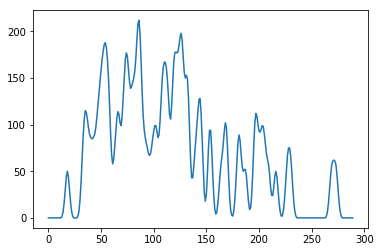

In [41]:
plt.plot(((input_data/(2**16))*256).astype(np.uint8))

In [ ]:
class BinaryLayerMeanGUI(AbstractGUI):
    
    def __init__(self, sensor, run=True):
        super().__init__(sensor)
        # Read data to initialise sizes
        _, data = self.sensor.read()
        # Determine data length as nearest power of 2 - will crop end of signal - ok with sound
        self.data_length_pow = np.log2(data.shape[0]).astype(np.uint8)
        # Create a list of panels for the GUI
        self.input_frame = SignalFrame(self.window, subpanels=2, width=512, height=256)
        self.diffs_frame = SignalFrame(self.window, subpanels=self.data_length_pow+1, width=256, height=64)
        self.means_frame = SignalFrame(self.window, subpanels=self.data_length_pow+1, width=256, height=64)
        self.summed_frame = SignalFrame(self.window, subpanels=self.data_length_pow+1, width=256, height=64)
            
        # Define rolling sums for each layer (including lowest)
        self.layer_sums = np.zeros(
            shape=(2**self.data_length_pow, self.data_length_pow+1), 
            dtype=np.int16
        )
            
        self.count = 0
        
        if run:
            self.run()
        
    
    def update(self):
        # Get audio frame
        _, data = self.sensor.read()
        clipped_data = data[:256]
        # PBT
        rand_ints = np.random.randint(255, size=(clipped_data.shape))
        binary_values = np.where(clipped_data > rand_ints, 1, 0).astype(np.uint8)
        # Update first set of panels
        self.input_frame.update([clipped_data, binary_values*255], signed=False)
        # Get differences via image pyramid
        diffs = get_differences_2D(binary_values[:256].reshape(-1, 1), clip=True)
        # Update diffs panels
        self.diffs_frame.update(diffs.T*255, signed=True)
        # Add to rolling sum
        self.layer_sums = self.layer_sums + diffs
        # Increment count
        self.count += 1
        # Check if count is at 256 and if so reduce by half
        if self.count >= 2**16-1:
            self.count = self.count // 2
            self.layer_sums = self.layer_sums // 2
            
        # Determine the probability
        mean_probs = self.layer_sums / self.count
        self.means_frame.update(mean_probs.T*255)
        
        # We need an extra step in here where we generate according to the probabilities
        
        # Then we sum the probabilities
        
        # Determine cumulative sums (flip to sum from bottom)
        cumsums = np.cumsum(np.flip(self.layer_sums, axis=1), axis=1) / self.count
        # Flip back to match means order
        flipped_cumsums = np.flip(cumsums, axis=1)
        # Display
        self.summed_frame.update(flipped_cumsums.T*255)
        
        self.window.after(30, self.update)